Replicate the corrected version of Muchlinksi et al. (2016). Specifically you should make the separation plots (Fig 1), ROC curves (Fig 2), F1-scores (Fig 3), and Table 1 for the main models in the paper.

In [1]:
library(randomForest)
library(caret)
library(ROCR)
library(pROC)
library(stepPlr)
library(doMC)
library(xtable)

randomForest 4.6-14

Type rfNews() to see new features/changes/bug fixes.

Loading required package: lattice

Loading required package: ggplot2


Attaching package: ‘ggplot2’


The following object is masked from ‘package:randomForest’:

    margin


Type 'citation("pROC")' for a citation.


Attaching package: ‘pROC’


The following objects are masked from ‘package:stats’:

    cov, smooth, var


Loading required package: foreach

Loading required package: iterators

Loading required package: parallel



## Load data

In [2]:
pred_data <- read.csv(file="./data/SambanisImp.csv")
causal_mech_data <- read.csv(file="./data/Amelia.Imp3.csv")

In [3]:
# Using only the 88 variables specified in Sambanis (2006) Appendix
pred_data.full <- pred_data[,
    c("warstds", "ager", "agexp", "anoc", "army85", "autch98", "auto4",
      "autonomy", "avgnabo", "centpol3", "coldwar", "decade1", "decade2",
      "decade3", "decade4", "dem", "dem4", "demch98", "dlang", "drel",
      "durable", "ef", "ef2", "ehet", "elfo", "elfo2", "etdo4590",
      "expgdp", "exrec", "fedpol3", "fuelexp", "gdpgrowth", "geo1", "geo2",
      "geo34", "geo57", "geo69", "geo8", "illiteracy", "incumb", "infant",
      "inst", "inst3", "life", "lmtnest", "ln_gdpen", "lpopns", "major", "manuexp", "milper",
      "mirps0", "mirps1", "mirps2", "mirps3", "nat_war", "ncontig",
      "nmgdp", "nmdp4_alt", "numlang", "nwstate", "oil", "p4mchg",
      "parcomp", "parreg", "part", "partfree", "plural", "plurrel",
      "pol4", "pol4m", "pol4sq", "polch98", "polcomp", "popdense",
      "presi", "pri", "proxregc", "ptime", "reg", "regd4_alt", "relfrac", "seceduc",
      "second", "semipol3", "sip2", "sxpnew", "sxpsq", "tnatwar", "trade",
      "warhist", "xconst")]

In [4]:
# Convert DV into Factor with names for Caret Library
pred_data.full$warstds <- factor(
    pred_data.full$warstds,
    levels=c(0,1),
    labels=c("peace", "war"))

## Train models

In [5]:
# distribute workload over multiple cores for faster computation
registerDoMC(cores=7)
set.seed(666)

In [6]:
# cross-validation function for the Caret Library
tc <- trainControl(method="cv",
    number=10,
    summaryFunction=twoClassSummary,
    classProb=T,
    savePredictions=T)

### Fearon and Laitin Model (2003)

In [7]:
model.fl.1 <- train(
    as.factor(warstds)~warhist+ln_gdpen+lpopns+lmtnest+ncontig+oil+nwstate
                      +inst3+pol4+ef+relfrac, #FL 2003 model spec
    metric="ROC", method="glm", family="binomial",
    trControl=tc, data=pred_data.full)

In [8]:
summary(model.fl.1)


Call:
NULL

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.0635  -0.1859  -0.1325  -0.0994   3.2962  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -8.46582    1.11539  -7.590 3.20e-14 ***
warhist      0.02247    0.25379   0.089  0.92946    
ln_gdpen    -0.35196    0.11791  -2.985  0.00284 ** 
lpopns       0.18788    0.06815   2.757  0.00584 ** 
lmtnest      0.18706    0.08049   2.324  0.02013 *  
ncontig      0.26477    0.28232   0.938  0.34831    
oil          0.33689    0.30155   1.117  0.26391    
nwstate      1.86032    0.32037   5.807 6.37e-09 ***
inst3        1.36212    0.20709   6.577 4.79e-11 ***
pol4        -0.02435    0.01781  -1.367  0.17170    
ef           0.44421    0.42340   1.049  0.29411    
relfrac      0.59413    0.50782   1.170  0.24202    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1185.9  on 7139  degrees 

### Fearon and Laitin Model (2003) penalized logistic regression

In [9]:
model.fl.2 <- train(
    as.factor(warstds)~warhist+ln_gdpen+lpopns+lmtnest+ncontig+oil+nwstate
                      +inst3+pol4+ef+relfrac, #FL 2003 model spec
    metric="ROC", method="plr",
    trControl=tc, data=pred_data.full)

In [10]:
summary(model.fl.2)


Call:
stepPlr::plr(x = x, y = y, weights = if (!is.null(wts)) wts else rep(1, 
    length(y)), lambda = param$lambda, cp = as.character(param$cp))

Coefficients:
          Estimate Std.Error z value Pr(>|z|)
Intercept  8.42662   1.10833   7.603    0.000
warhist   -0.01827   0.25031  -0.073    0.942
ln_gdpen   0.35579   0.11704   3.040    0.002
lpopns    -0.18719   0.06783  -2.760    0.006
lmtnest   -0.18629   0.08026  -2.321    0.020
ncontig   -0.26372   0.27765  -0.950    0.342
oil       -0.33176   0.29554  -1.123    0.261
nwstate   -1.82097   0.31626  -5.758    0.000
inst3     -1.34669   0.20509  -6.566    0.000
pol4       0.02400   0.01774   1.353    0.176
ef        -0.43870   0.40566  -1.081    0.280
relfrac   -0.57091   0.48055  -1.188    0.235

    Null deviance: 1185.92 on 7139 degrees of freedom
Residual deviance: 1057.21 on 7128.16 degrees of freedom
            Score: deviance + 8.9 * df = 1162.24 


### Collier and Hoeffler Model (2004) 


In [11]:
model.ch.1 <- train(
    as.factor(warstds)~sxpnew+sxpsq+ln_gdpen+gdpgrowth+warhist+lmtnest+ef+popdense
                      +lpopns+coldwar+seceduc+ptime,
    metric="ROC", method="glm", family="binomial",
    trControl=tc, data=pred_data.full)

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


In [12]:
summary(model.ch.1)


Call:
NULL

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.1130  -0.1837  -0.1161  -0.0777   3.5875  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept) -6.945e+00  1.251e+00  -5.550 2.86e-08 ***
sxpnew       1.768e+01  4.288e+00   4.123 3.74e-05 ***
sxpsq       -7.685e+01  1.125e+01  -6.831 8.42e-12 ***
ln_gdpen    -4.402e-01  1.418e-01  -3.104  0.00191 ** 
gdpgrowth   -6.783e+00  1.228e+00  -5.525 3.29e-08 ***
warhist     -5.266e-01  2.612e-01  -2.016  0.04378 *  
lmtnest      2.332e-01  8.192e-02   2.846  0.00443 ** 
ef          -1.118e-02  4.446e-01  -0.025  0.97993    
popdense    -1.463e-04  9.093e-04  -0.161  0.87217    
lpopns       2.265e-01  6.922e-02   3.272  0.00107 ** 
coldwar     -1.081e-01  2.678e-01  -0.404  0.68642    
seceduc     -5.562e-03  5.650e-03  -0.984  0.32490    
ptime       -2.279e-03  7.607e-04  -2.996  0.00273 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter

### Collier and Hoeffler (2004) penalized logistic regression

In [13]:
model.ch.2 <- train(
    as.factor(warstds)~sxpnew+sxpsq+ln_gdpen+gdpgrowth+warhist+lmtnest+ef+popdense
                      +lpopns+coldwar+seceduc+ptime,
    metric="ROC", method="plr",
    trControl=tc, data=pred_data.full)


Convergence warning in plr: 2 


In [14]:
summary(model.ch.2)


Call:
stepPlr::plr(x = x, y = y, weights = if (!is.null(wts)) wts else rep(1, 
    length(y)), lambda = param$lambda, cp = as.character(param$cp))

Coefficients:
          Estimate Std.Error z value Pr(>|z|)
Intercept  5.69042   1.19736   4.752    0.000
sxpnew     6.67340   4.99964   1.335    0.182
sxpsq      4.92896  11.66979   0.422    0.673
ln_gdpen   0.39857   0.12910   3.087    0.002
gdpgrowth  6.77561   1.21447   5.579    0.000
warhist    0.18392   0.26007   0.707    0.480
lmtnest   -0.17193   0.07845  -2.192    0.028
ef        -0.31249   0.43698  -0.715    0.475
popdense   0.00108   0.00116   0.931    0.352
lpopns    -0.18365   0.06734  -2.727    0.006
coldwar   -0.03555   0.26632  -0.133    0.894
seceduc    0.00822   0.00557   1.476    0.140
ptime      0.00118   0.00073   1.616    0.106

    Null deviance: 1185.92 on 7139 degrees of freedom
Residual deviance: 1048.64 on 7127 degrees of freedom
            Score: deviance + 8.9 * df = 1163.99 


### Hegre and Sambanis (2006) Model 

In [15]:
model.hs.1 <- train(
    warstds~lpopns+ln_gdpen+inst3+parreg+geo34+proxregc+gdpgrowth+anoc
           +partfree+nat_war+lmtnest+decade1+pol4sq+nwstate+regd4_alt+etdo4590+milper
           +geo1+tnatwar+presi,
    metric="ROC", method="glm", family="binomial",
    trControl=tc, data=pred_data.full)

In [16]:
summary(model.hs.1)


Call:
NULL

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.3271  -0.1876  -0.1212  -0.0719   3.7643  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept) -7.882e+00  1.336e+00  -5.901 3.62e-09 ***
lpopns       2.314e-01  7.381e-02   3.135  0.00172 ** 
ln_gdpen    -2.978e-01  1.318e-01  -2.259  0.02386 *  
inst3        1.410e+00  2.476e-01   5.694 1.24e-08 ***
parreg      -2.933e-01  1.364e-01  -2.151  0.03151 *  
geo34       -1.062e-01  3.163e-01  -0.336  0.73709    
proxregc    -9.256e-01  3.118e-01  -2.968  0.00300 ** 
gdpgrowth   -6.224e+00  1.209e+00  -5.148 2.63e-07 ***
anoc         4.359e-01  3.037e-01   1.435  0.15119    
partfree     9.320e-02  2.734e-01   0.341  0.73315    
nat_war      1.000e+00  3.119e-01   3.206  0.00134 ** 
lmtnest      1.652e-01  7.996e-02   2.066  0.03883 *  
decade1      1.870e-01  2.563e-01   0.729  0.46574    
pol4sq       2.510e-03  5.606e-03   0.448  0.65428    
nwstate      1.872e+00  3.526e-01 

### Hegre and Sambanis (2006) penalized logistic regression

In [17]:
model.hs.2 <- train(
    warstds~lpopns+ln_gdpen+inst3+parreg+geo34+proxregc+gdpgrowth+anoc
           +partfree+nat_war+lmtnest+decade1+pol4sq+nwstate+regd4_alt+etdo4590+milper
           +geo1+tnatwar+presi,
    metric="ROC", method="plr",
    trControl=tc, data=pred_data.full)


Convergence warning in plr: 2 


In [18]:
summary(model.hs.2)


Call:
stepPlr::plr(x = x, y = y, weights = if (!is.null(wts)) wts else rep(1, 
    length(y)), lambda = param$lambda, cp = as.character(param$cp))

Coefficients:
          Estimate Std.Error z value Pr(>|z|)
Intercept  6.68751   1.31047   5.103    0.000
lpopns    -0.17152   0.07319  -2.343    0.019
ln_gdpen   0.30106   0.13110   2.296    0.022
inst3     -1.41477   0.24655  -5.738    0.000
parreg     0.33586   0.13389   2.508    0.012
geo34      0.11543   0.31329   0.368    0.713
proxregc   0.92051   0.30956   2.974    0.003
gdpgrowth  5.30115   1.25502   4.224    0.000
anoc      -0.37100   0.30178  -1.229    0.219
partfree  -0.06924   0.27214  -0.254    0.799
nat_war   -1.00776   0.31103  -3.240    0.001
lmtnest   -0.16578   0.07927  -2.091    0.037
decade1   -0.16346   0.25583  -0.639    0.523
pol4sq    -0.00173   0.00558  -0.310    0.757
nwstate   -1.85961   0.34976  -5.317    0.000
regd4_alt  0.05579   0.02847   1.960    0.050
etdo4590  -0.00063   0.22750  -0.003    0.998
milper   

### Random Forest

In [19]:
model.rf <- train(
    as.factor(warstds)~.,
    metric="ROC", method="rf",
    sampsize=c(30,90),
    importance=T,
    proximity=F, 
    ntree=1000,
    trControl=tc, data=pred_data.full)

In [20]:
summary(model.rf)

                Length Class      Mode     
call                8  -none-     call     
type                1  -none-     character
predicted        7140  factor     numeric  
err.rate         3000  -none-     numeric  
confusion           6  -none-     numeric  
votes           14280  matrix     numeric  
oob.times        7140  -none-     numeric  
classes             2  -none-     character
importance        360  -none-     numeric  
importanceSD      270  -none-     numeric  
localImportance     0  -none-     NULL     
proximity           0  -none-     NULL     
ntree               1  -none-     numeric  
mtry                1  -none-     numeric  
forest             14  -none-     list     
y                7140  factor     numeric  
test                0  -none-     NULL     
inbag               0  -none-     NULL     
xNames             90  -none-     character
problemType         1  -none-     character
tuneValue           1  data.frame list     
obsLevels           2  -none-   

## Figure 2 (ROC Curves)

In [21]:
pred.FL.war<-model.fl.1$finalModel$fitted.values
pred.CH.war<-model.ch.1$finalModel$fitted.values
pred.HR.war<-model.hs.1$finalModel$fitted.values

In [22]:
RF.1.pred<-predict(model.rf$finalModel, type="prob")
RF.1.pred<-as.data.frame(RF.1.pred)

In [23]:
pred.FL <- prediction(pred.FL.war, pred_data.full$warstds)
perf.FL <- performance(pred.FL,"tpr","fpr")
pred.CH <- prediction(pred.CH.war, pred_data.full$warstds)
perf.CH <- performance(pred.CH,"tpr","fpr")
pred.HS<-prediction(pred.HR.war, pred_data.full$warstds)
perf.HS<-performance(pred.HS, "tpr", "fpr")
pred.RF.1<-prediction(RF.1.pred$war, pred_data.full$warstds)
perf.RF.1<-performance(pred.RF.1, "tpr", "fpr")

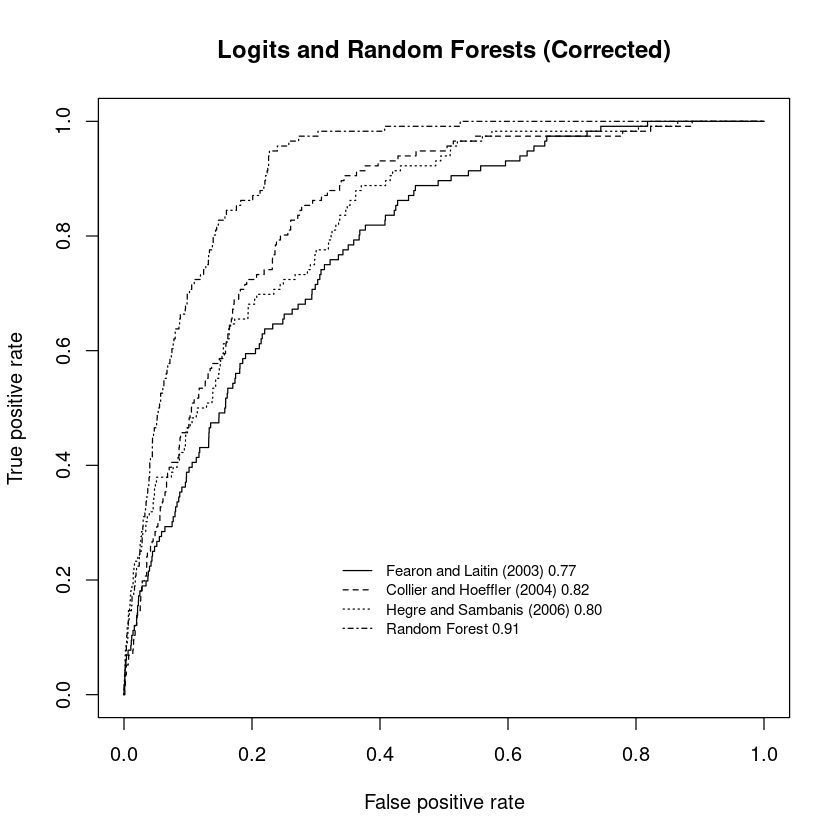

In [24]:
plot(perf.FL, main="Logits and Random Forests (Corrected)")
plot(perf.CH, add=T, lty=2)
plot(perf.HS, add=T, lty=3)
plot(perf.RF.1, add=T, lty=4)
legend(0.32, 0.25, 
       c("Fearon and Laitin (2003) 0.77", "Collier and Hoeffler (2004) 0.82",
         "Hegre and Sambanis (2006) 0.80", "Random Forest 0.91" ),
       lty=c(1,2,3,4), bty="n", cex = .75)

In [25]:
FL.2.pred<-1-model.fl.2$finalModel$fitted.values
CH.2.pred<-1-model.ch.2$finalModel$fitted.values
HS.2.pred<-1-model.hs.2$finalModel$fitted.values

In [26]:
pred.FL.2 <- prediction(FL.2.pred, pred_data.full$warstds)
perf.FL.2 <- performance(pred.FL.2,"tpr","fpr")
pred.CH.2<- prediction(CH.2.pred, pred_data.full$warstds)
perf.CH.2 <- performance(pred.CH.2,"tpr","fpr")
pred.HS.2<- prediction(HS.2.pred, pred_data.full$warstds)
perf.HS.2 <- performance(pred.HS.2,"tpr","fpr")

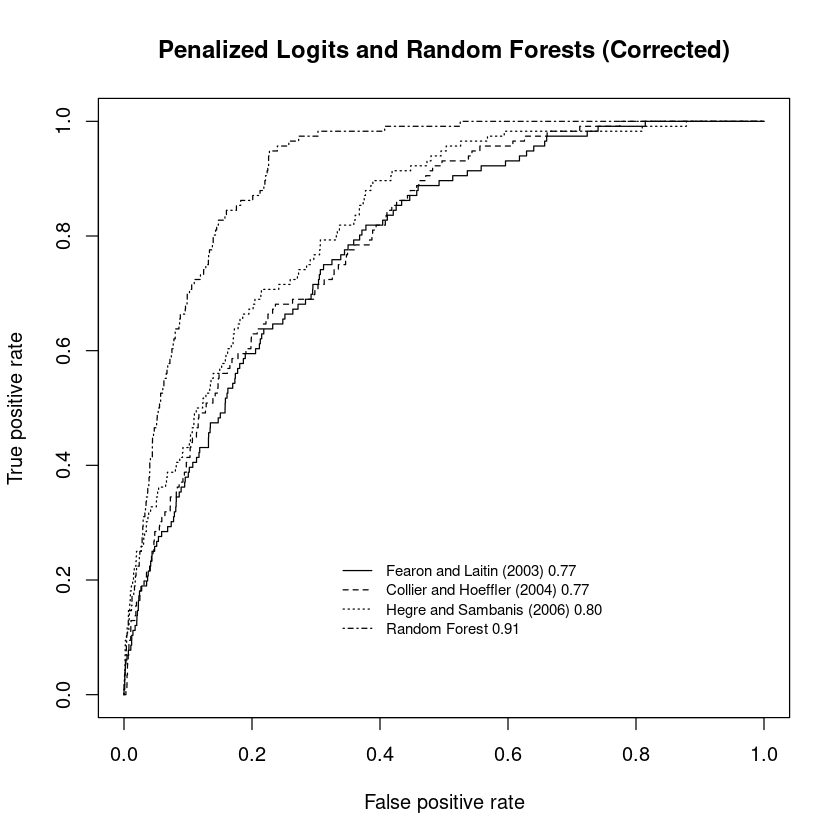

In [27]:
plot(perf.FL.2, main="Penalized Logits and Random Forests (Corrected)")
plot(perf.CH.2, add=T, lty=2)
plot(perf.HS.2, add=T, lty=3)
plot(perf.RF.1, add=T, lty=4)
legend(0.32, 0.25, 
       c("Fearon and Laitin (2003) 0.77",
         "Collier and Hoeffler (2004) 0.77",
         "Hegre and Sambanis (2006) 0.80",
         "Random Forest 0.91" ), 
       lty=c(1,2,3,4), bty="n", cex = .75)

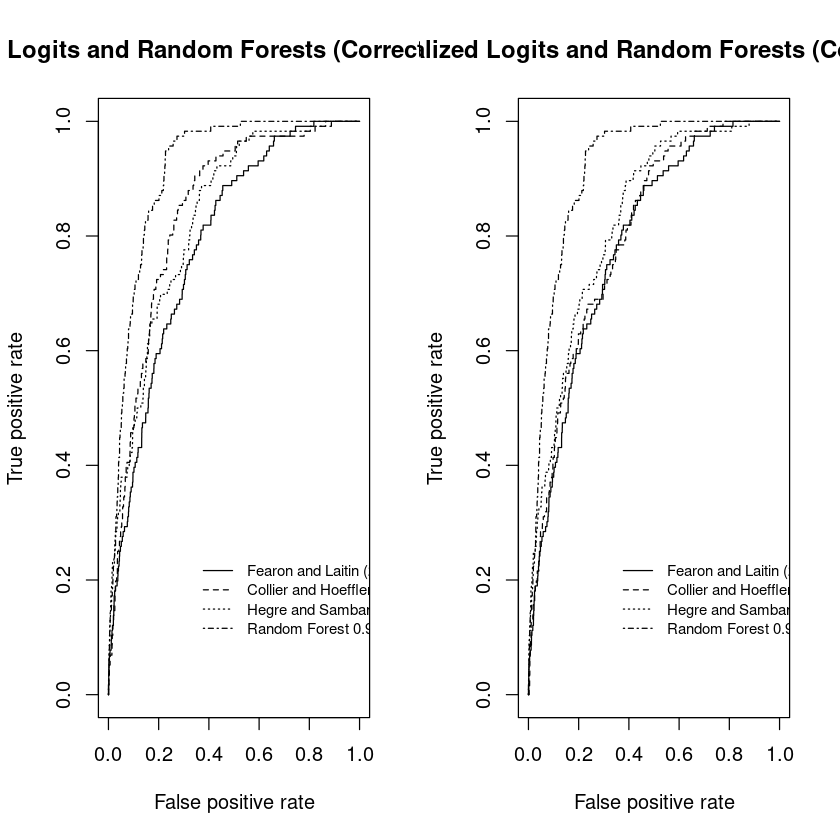

In [28]:
### Combine both ROC plots
par(mfrow=c(1,2))
plot(perf.FL, main="Logits and Random Forests (Corrected)")
plot(perf.CH, add=T, lty=2)
plot(perf.HS, add=T, lty=3)
plot(perf.RF.1, add=T, lty=4)
legend(0.32, 0.25, 
       c("Fearon and Laitin (2003) 0.77", "Collier and Hoeffler (2004) 0.82",
         "Hegre and Sambanis (2006) 0.80", "Random Forest 0.91" ),
       lty=c(1,2,3,4), bty="n", cex = .75)
plot(perf.FL.2, main="Penalized Logits and Random Forests (Corrected)")
plot(perf.CH.2, add=T, lty=2)
plot(perf.HS.2, add=T, lty=3)
plot(perf.RF.1, add=T, lty=4)
legend(0.32, 0.25,
       c("Fearon and Laitin (2003) 0.77", "Collier and Hoeffler (2004) 0.77",
         "Hegre and Sambanis (2006) 0.80", "Random Forest 0.91" ),
       lty=c(1,2,3,4), bty="n", cex = .75)

## Figure 1 (separation plots)

In [29]:
library(separationplot)

Loading required package: RColorBrewer

Loading required package: Hmisc

Loading required package: survival


Attaching package: ‘survival’


The following object is masked from ‘package:caret’:

    cluster


Loading required package: Formula


Attaching package: ‘Hmisc’


The following objects are masked from ‘package:xtable’:

    label, label<-


The following objects are masked from ‘package:base’:

    format.pval, units


Loading required package: MASS

Loading required package: foreign



Transform DV back to 0,1 values for separation plots

In [30]:
pred_data.full$warstds <- factor(
    pred_data.full$warstds,
    levels=c("peace","war"),
    labels=c(0, 1))

Transform actual observations into vector for separation plots

In [31]:
Warstds <- as.vector(pred_data.full$warstds)

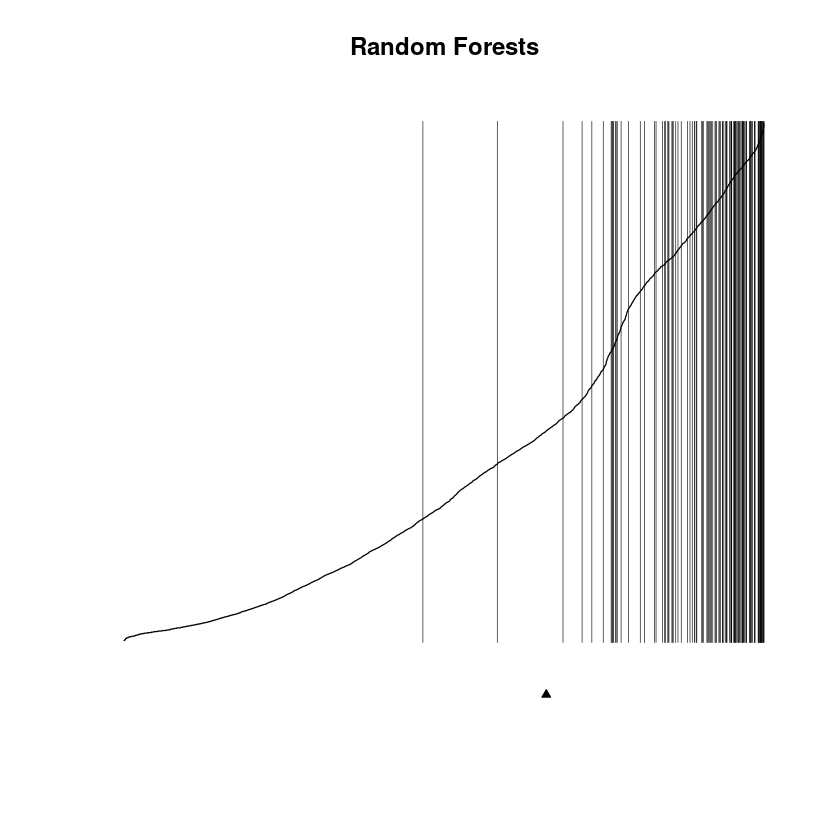

In [46]:
separationplot(
    RF.1.pred$war,
    Warstds,
    type="line",
    line=T,
    lwd2=1,
    show.expected=T,
    heading="Random Forests", height=2.5, col0="white", col1="black", newplot=F)

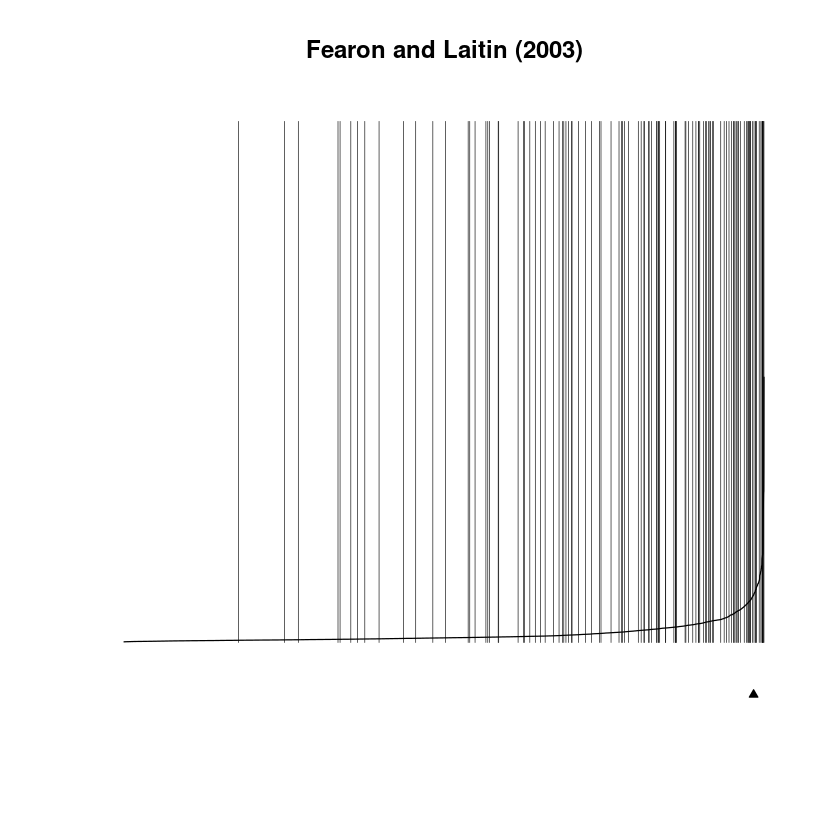

In [47]:
separationplot(
    pred.FL.war, Warstds, type="line", line=T, lwd2=1, show.expected=T,
    heading="Fearon and Laitin (2003)", height=2.5, col0="white", col1="black", newplot=F)

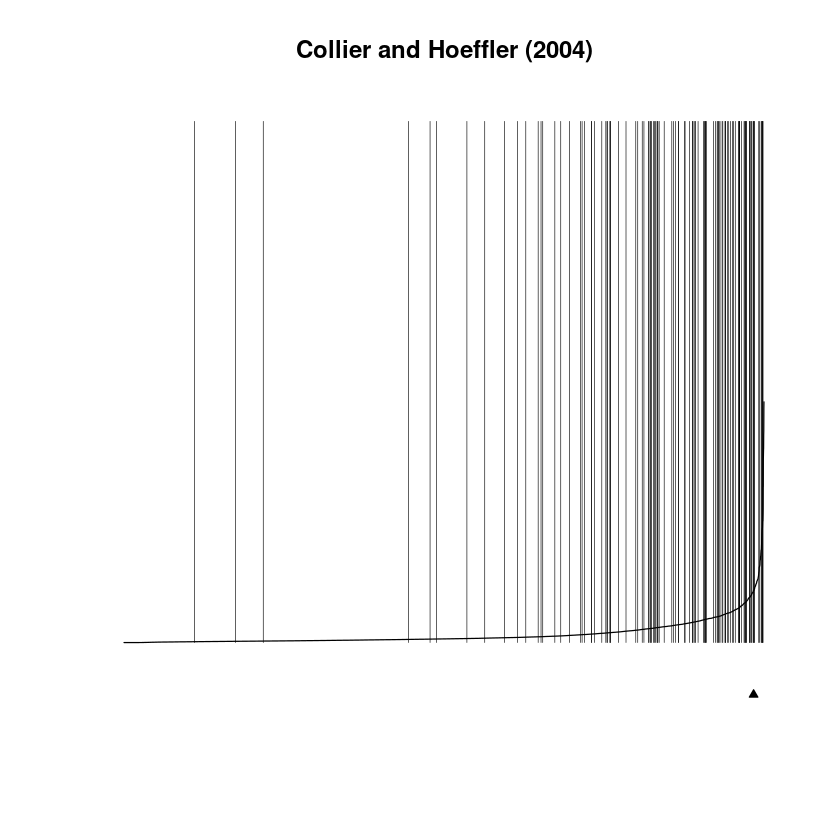

In [48]:
separationplot(
    pred.CH.war, Warstds, type="line", line=T, lwd2=1, show.expected=T,
    heading="Collier and Hoeffler (2004)", height=2.5, col0="white", col1="black", newplot=F)

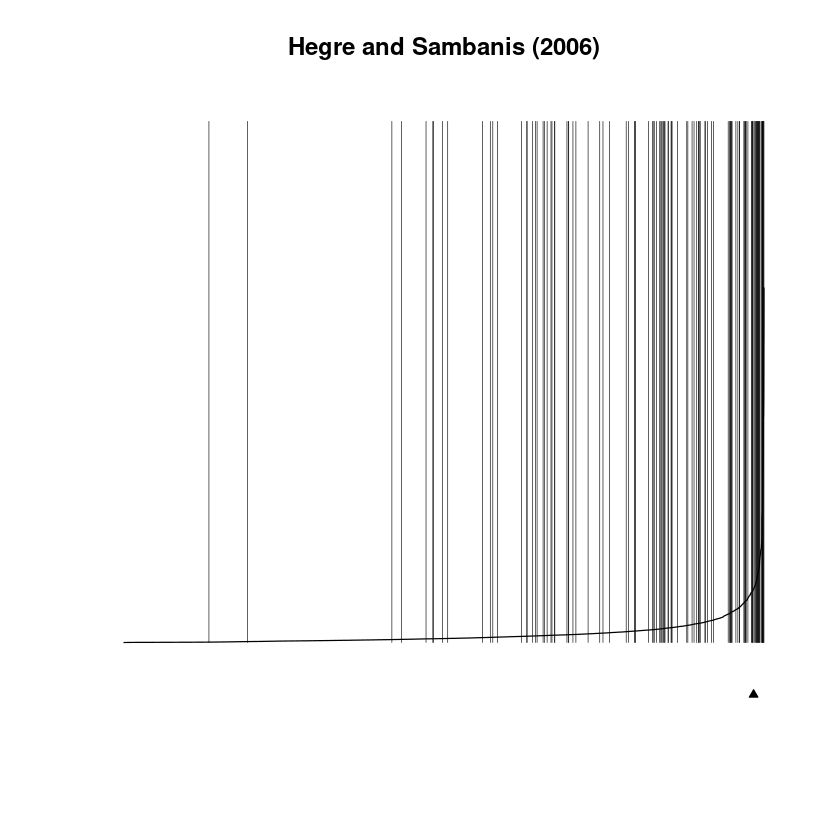

In [49]:
separationplot(
    pred.HR.war, Warstds, type="line", line=T, lwd2=1, show.expected=T,
    heading="Hegre and Sambanis (2006)", height=2.5, col0="white", col1="black", newplot=F)

## Figure 3

## Table 1

In [52]:
set.seed(425)
data_imp <- read.csv(file="./data/data_full.csv")
rf.imp <- rfImpute(data_imp, as.factor(data_imp$warstds), iter=5, ntree=1000)

ntree      OOB      1      2
 1000:   0.02%  0.00%  1.48%
ntree      OOB      1      2
 1000:   0.02%  0.00%  1.48%
ntree      OOB      1      2
 1000:   0.04%  0.00%  2.22%
ntree      OOB      1      2
 1000:   0.06%  0.00%  3.70%
ntree      OOB      1      2
 1000:   0.01%  0.00%  0.74%


In [53]:
mena <- subset(rf.imp, rf.imp$year > 2000)

In [55]:
fl.pred<-predict(model.fl.1, newdata=mena, type="prob")
fl.pred<-as.data.frame(fl.pred)
pred.FL.1<-prediction(fl.pred$war, mena$`as.factor(data_imp$warstds)`)
perf.FL.1<-performance(pred.FL.1, "auc")

ch.pred<-predict(model.ch.1, newdata=mena, type="prob")
ch.pred<-as.data.frame(ch.pred)
pred.CH.1<-prediction(ch.pred$war, mena$`as.factor(data_imp$warstds)`)
perf.CH.1<-performance(pred.CH.1, "auc")

hs.pred<-predict(model.hs.1, newdata=mena, type="prob")
hs.pred<-as.data.frame(hs.pred)
pred.HS.1<-prediction(hs.pred$war, mena$`as.factor(data_imp$warstds)`)
perf.HS.1<-performance(pred.HS.1, "auc")

rf.pred<-predict(model.rf, newdata=mena, type="prob")
rf.pred<-as.data.frame(rf.pred)
pred.RF.1<-prediction(rf.pred$war, mena$`as.factor(data_imp$warstds)`)
perf.RF.1<-performance(pred.RF.1, "tpr", "fpr")
perf.RF.1<-performance(pred.RF.1, "auc")

In [56]:
predictions<-cbind(mena$cowcode, mena$year, mena$warstds, fl.pred[,2], ch.pred[,2],
hs.pred[,2], rf.pred[,2])

In [58]:
colnames(predictions)<-c("COWcode", "year", "CW_Onset", "Fearon and Latin (2003)",
"Collier and Hoeffler (2004)", "Hegre and Sambanis (2006)",
"Random Forest")
predictions<-as.data.frame(predictions)
Onset_table<-predictions[order(-predictions$CW_Onset, predictions$year),]
Onset_table_1thru19<-head(Onset_table, n=19)
xtable(Onset_table_1thru19)
# uncomment to write this to a CSV
# write.csv(predictions, file="testing_file_CW_onset_RF_rep_final.csv")

,COWcode,year,CW_Onset,Fearon and Latin (2003),Collier and Hoeffler (2004),Hegre and Sambanis (2006),Random Forest
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
127,438,2001,1,0.007643157,0.004191886,0.006491767,0.070
351,516,2001,1,0.029228931,0.003032128,0.018701560,0.087
365,517,2001,1,0.008109073,0.002871234,0.006613362,0.046
435,540,2001,1,0.012828092,0.011095105,0.016913126,0.713
883,700,2001,1,0.007259153,0.003565428,0.004751861,0.064
296,500,2002,1,0.015394016,0.021599486,0.020239060,0.928
157,450,2003,1,0.016241764,0.037933291,0.026775852,0.981
298,500,2004,1,0.010231514,0.004850783,0.011289025,0.449
704,645,2004,1,0.031794188,0.005469389,0.027515971,0.162
